In [31]:
from matplotlib import pyplot as plt
import os
import numpy as np
import json
from typing import Any, Iterable, Union
from pathlib import Path

file_dir = "../outputs/12_26/"
model_list = ["Qwen/QwQ-32B-Preview", "Qwen/Qwen2.5-32B-Instruct", "Qwen/Qwen2.5-14B-Instruct", "Qwen/Qwen2.5-7B-Instruct", "Qwen/Qwen2.5-3B-Instruct", "Qwen/Qwen2.5-1.5B-Instruct", "mistralai/Mathstral-7B-v0.1", "Skywork/Skywork-o1-Open-Llama-3.1-8B"]

colors = ["red", "orange", "green", "blue", "purple", "pink", "brown", "gray", "black", "white"]

In [32]:
def gen_budget_list():
    # 注意有的模型性能比较好，在某些数据集上没跑完全部的budget
    budget_list = []
    for i in range(25, 951, 25):
        budget_list.append(i)
    # for i in range(1000, 1501, 50):
    #     budget_list.append(i)
    return budget_list

def gen_budget_list_hard():
    # hard截断需要比step-by-step多25个token
    budget_list = []
    for i in range(50, 976, 25):
        budget_list.append(i)
    # for i in range(1000, 1501, 50):
    #     budget_list.append(i)
    return budget_list

In [33]:

prompt_type1 = "qwen25-step-by-step-hard"
prompt_type2 = "qwen25-math-cot"
prompt_type3 = "coarse-to-fine-qwen"
prompt_type4 = "mathstral-step-by-step-hard"
prompt_type5 = "mathstral-step-by-step"
prompt_type6 = "mathstral-coarse-to-fine"
prompt_type7 = "skywork-step-by-step-hard"
prompt_type8 = "skywork-step-by-step"
prompt_type9 = "skywork-coarse-to-fine"


dataset = "math"
something = "_-1_seed0_t0.0_s0_e-1"
budget_list1 = gen_budget_list()
budget_list2 = gen_budget_list_hard()

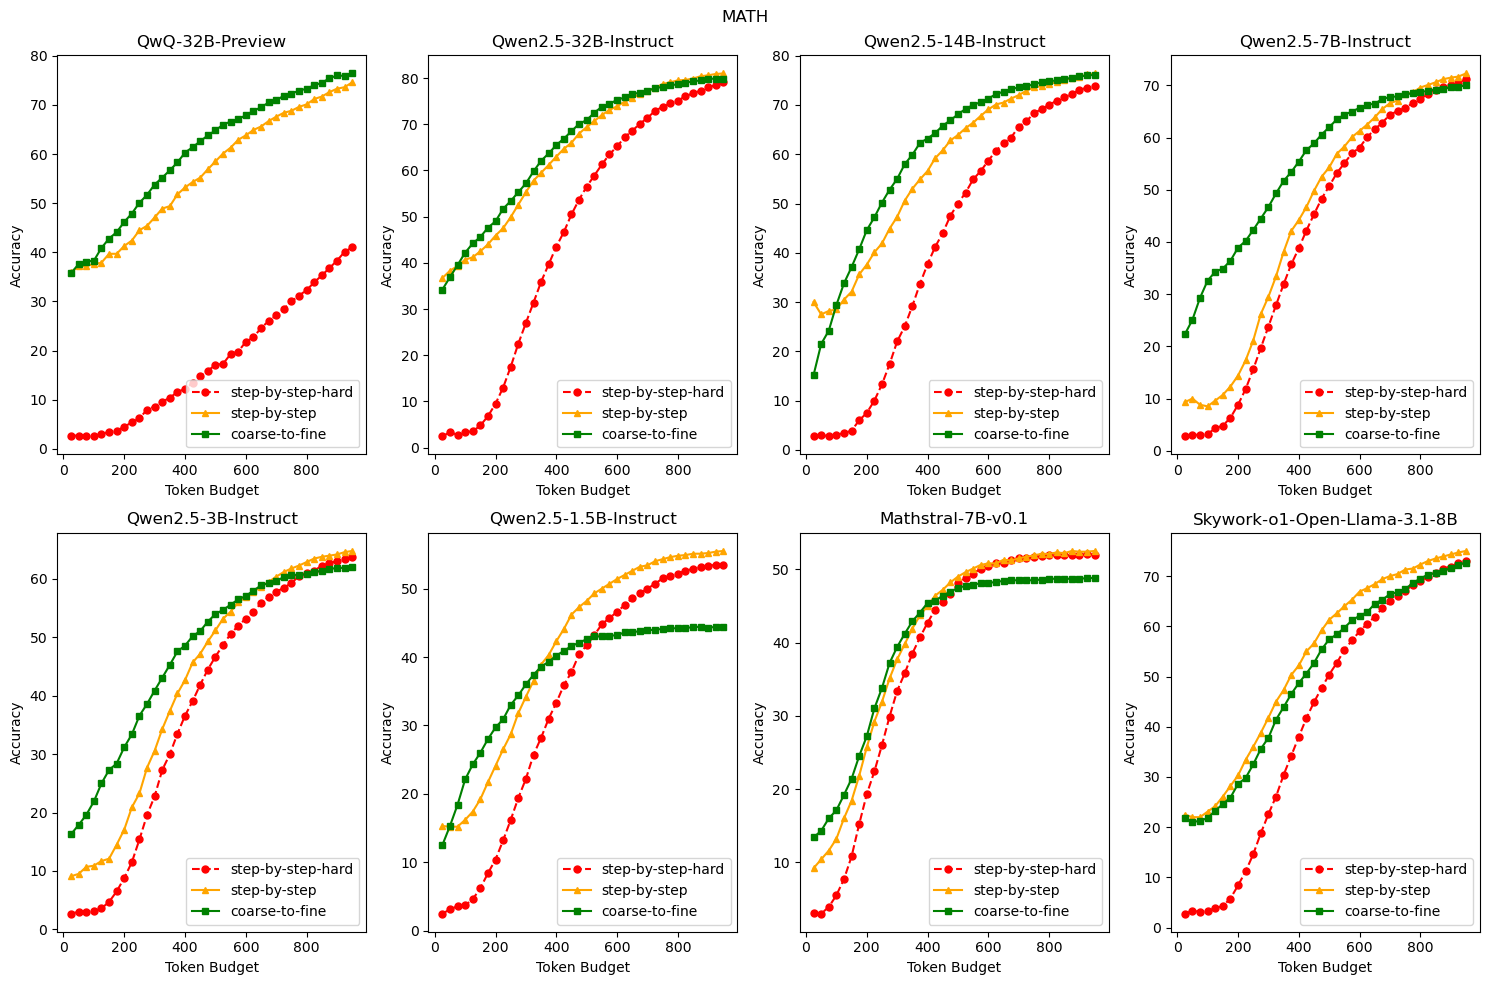

In [34]:
acc_lists1 = []
acc_lists2 = []
acc_lists3 = []

for model in model_list:
    acc_list1 = []
    acc_list2 = []
    acc_list3 = []
    for budget in budget_list1:
        if model.startswith("Qwen"):
            file_name2 = "test_" + prompt_type2 + something + "_b" + str(int(budget)) + "_metrics.json"
            file_name3 = "test_" + prompt_type3 + something + "_b" + str(int(budget)) + "_metrics.json"
            file_path2 = os.path.join(file_dir, model, prompt_type2, dataset, file_name2)
            file_path3 = os.path.join(file_dir, model, prompt_type3, dataset, file_name3)
        elif model.startswith("mistralai"):
            file_name2 = "test_" + prompt_type5 + something + "_b" + str(int(budget)) + "_metrics.json"
            file_name3 = "test_" + prompt_type6 + something + "_b" + str(int(budget)) + "_metrics.json"
            file_path2 = os.path.join(file_dir, model, prompt_type5, dataset, file_name2)
            file_path3 = os.path.join(file_dir, model, prompt_type6, dataset, file_name3)
        elif model.startswith("Skywork"):
            file_name2 = "test_" + prompt_type8 + something + "_b" + str(int(budget)) + "_metrics.json"
            file_name3 = "test_" + prompt_type9 + something + "_b" + str(int(budget)) + "_metrics.json"
            file_path2 = os.path.join(file_dir, model, prompt_type8, dataset, file_name2)
            file_path3 = os.path.join(file_dir, model, prompt_type9, dataset, file_name3)
        with open(file_path2, "r") as f:
            acc_list2.append(json.load(f)["acc"])
        with open(file_path3, "r") as f:
            acc_list3.append(json.load(f)["acc"])
    for budget in budget_list2:
        if model.startswith("Qwen"):
            file_name1 = "test_" + prompt_type1 + something + "_b" + str(int(budget)) + "_metrics.json"
            file_path1 = os.path.join(file_dir, model, prompt_type1, dataset, file_name1)
        elif model.startswith("mistralai"):
            file_name1 = "test_" + prompt_type4 + something + "_b" + str(int(budget)) + "_metrics.json"
            file_path1 = os.path.join(file_dir, model, prompt_type4, dataset, file_name1)
        elif model.startswith("Skywork"):
            file_name1 = "test_" + prompt_type7 + something + "_b" + str(int(budget)) + "_metrics.json"
            file_path1 = os.path.join(file_dir, model, prompt_type7, dataset, file_name1)
        with open(file_path1, "r") as f:
            acc_list1.append(json.load(f)["acc"])
    acc_lists1.append(acc_list1)
    acc_lists2.append(acc_list2)
    acc_lists3.append(acc_list3)
    
    

# Create a 2x3 subplot
fig, axs = plt.subplots(2, 4, figsize=(15, 10))
marker_size = 5  # Set the desired marker size

# Flatten the axes array for easy iteration
axs = axs.flatten()
# Plot all lines first without labels
for index, model in enumerate(model_list):
    axs[index].plot(budget_list1, acc_lists1[index], marker='o', markersize=marker_size, 
                         linestyle='--', color="red", label="step-by-step-hard")
    axs[index].plot(budget_list1, acc_lists2[index], marker='^', markersize=marker_size, 
                     linestyle='-', color="orange", label="step-by-step")
    axs[index].plot(budget_list1, acc_lists3[index], marker='s', markersize=marker_size, 
                     linestyle='-', color="green", label="coarse-to-fine")
    axs[index].set_xlabel("Token Budget")
    axs[index].set_ylabel("Accuracy")
    axs[index].set_title(f"{model.split('/')[-1]}")
    axs[index].legend()

# set the title
plt.suptitle(f"{dataset}".upper())
# Adjust layout
plt.tight_layout()


In [35]:
def load_jsonl(file: Union[str, Path]) -> Iterable[Any]:
    with open(file, "r", encoding="utf-8") as f:
        for line in f:
            try:
                yield json.loads(line)
            except:
                print("Error in loading:", line)
                exit()

def get_level_acc(data_path):
    data_list = load_jsonl(data_path)
    accs = {
        "Level 1": [],
        "Level 2": [],
        "Level 3": [],
        "Level 4": [],
        "Level 5": []
    }
    nums = {
        "Level 1": 0,
        "Level 2": 0,
        "Level 3": 0,
        "Level 4": 0,
        "Level 5": 0
    }
    for data in data_list:
        accs[data["level"]].append(data["score"][0])
        nums[data["level"]] += 1
    for level in accs:
        accs[level] = round(np.mean(accs[level]) * 100, 2)
    # print(accs)
    # print(nums)
    # print("sum of nums:", sum(nums.values()))
    # # save the accs to the metric_path
    # with open(metric_path, "r", encoding="utf-8") as f:
    #     metrics = json.load(f)
    #     for i in range(5):
    #         metrics["Level " + str(i + 1)] = accs["Level " + str(i + 1)]
    # with open(metric_path, "w", encoding="utf-8") as f:
    #     json.dump(metrics, f)
    return accs


test_data_path = "/home/sunyi/CoT/Time-Constrained-CoT/outputs/12_26/Qwen/Qwen2.5-7B-Instruct/qwen25-math-cot/math/test_qwen25-math-cot_-1_seed0_t0.0_s0_e-1_b200.jsonl"
test_metric_path = "/home/sunyi/CoT/Time-Constrained-CoT/outputs/12_26/Qwen/Qwen2.5-7B-Instruct/qwen25-math-cot/math/test_qwen25-math-cot_-1_seed0_t0.0_s0_e-1_b200_metrics.json"
get_level_acc(test_data_path)

{'Level 1': 41.42,
 'Level 2': 22.26,
 'Level 3': 15.21,
 'Level 4': 9.06,
 'Level 5': 4.46}

In [36]:
# plot acc for each level

acc_lists1 = []
acc_lists2 = []
acc_lists3 = []

for model in model_list:
    acc_list1 = []
    acc_list2 = []
    acc_list3 = []
    for budget in budget_list1:
        if model.startswith("Qwen"):
            data_file2 = "test_" + prompt_type2 + something + "_b" + str(int(budget)) + ".jsonl"
            data_file3 = "test_" + prompt_type3 + something + "_b" + str(int(budget)) + ".jsonl"
            data_path2 = os.path.join(file_dir, model, prompt_type2, dataset, data_file2)
            data_path3 = os.path.join(file_dir, model, prompt_type3, dataset, data_file3)
        elif model.startswith("mistralai"):
            data_file2 = "test_" + prompt_type5 + something + "_b" + str(int(budget)) + ".jsonl"
            data_file3 = "test_" + prompt_type6 + something + "_b" + str(int(budget)) + ".jsonl"
            data_path2 = os.path.join(file_dir, model, prompt_type5, dataset, data_file2)
            data_path3 = os.path.join(file_dir, model, prompt_type6, dataset, data_file3)
        elif model.startswith("Skywork"):
            data_file2 = "test_" + prompt_type8 + something + "_b" + str(int(budget)) + ".jsonl"
            data_file3 = "test_" + prompt_type9 + something + "_b" + str(int(budget)) + ".jsonl"
            data_path2 = os.path.join(file_dir, model, prompt_type8, dataset, data_file2)
            data_path3 = os.path.join(file_dir, model, prompt_type9, dataset, data_file3)
        acc_list2.append(get_level_acc(data_path2))
        acc_list3.append(get_level_acc(data_path3))
    for budget in budget_list2:
        if model.startswith("Qwen"):
            data_file1 = "test_" + prompt_type1 + something + "_b" + str(int(budget)) + ".jsonl"
            data_path1 = os.path.join(file_dir, model, prompt_type1, dataset, data_file1)
        elif model.startswith("mistralai"):
            data_file1 = "test_" + prompt_type4 + something + "_b" + str(int(budget)) + ".jsonl"
            data_path1 = os.path.join(file_dir, model, prompt_type4, dataset, data_file1)
        elif model.startswith("Skywork"):
            data_file1 = "test_" + prompt_type7 + something + "_b" + str(int(budget)) + ".jsonl"
            data_path1 = os.path.join(file_dir, model, prompt_type7, dataset, data_file1)
        acc_list1.append(get_level_acc(data_path1))
    acc_lists1.append(acc_list1)
    acc_lists2.append(acc_list2)
    acc_lists3.append(acc_list3)


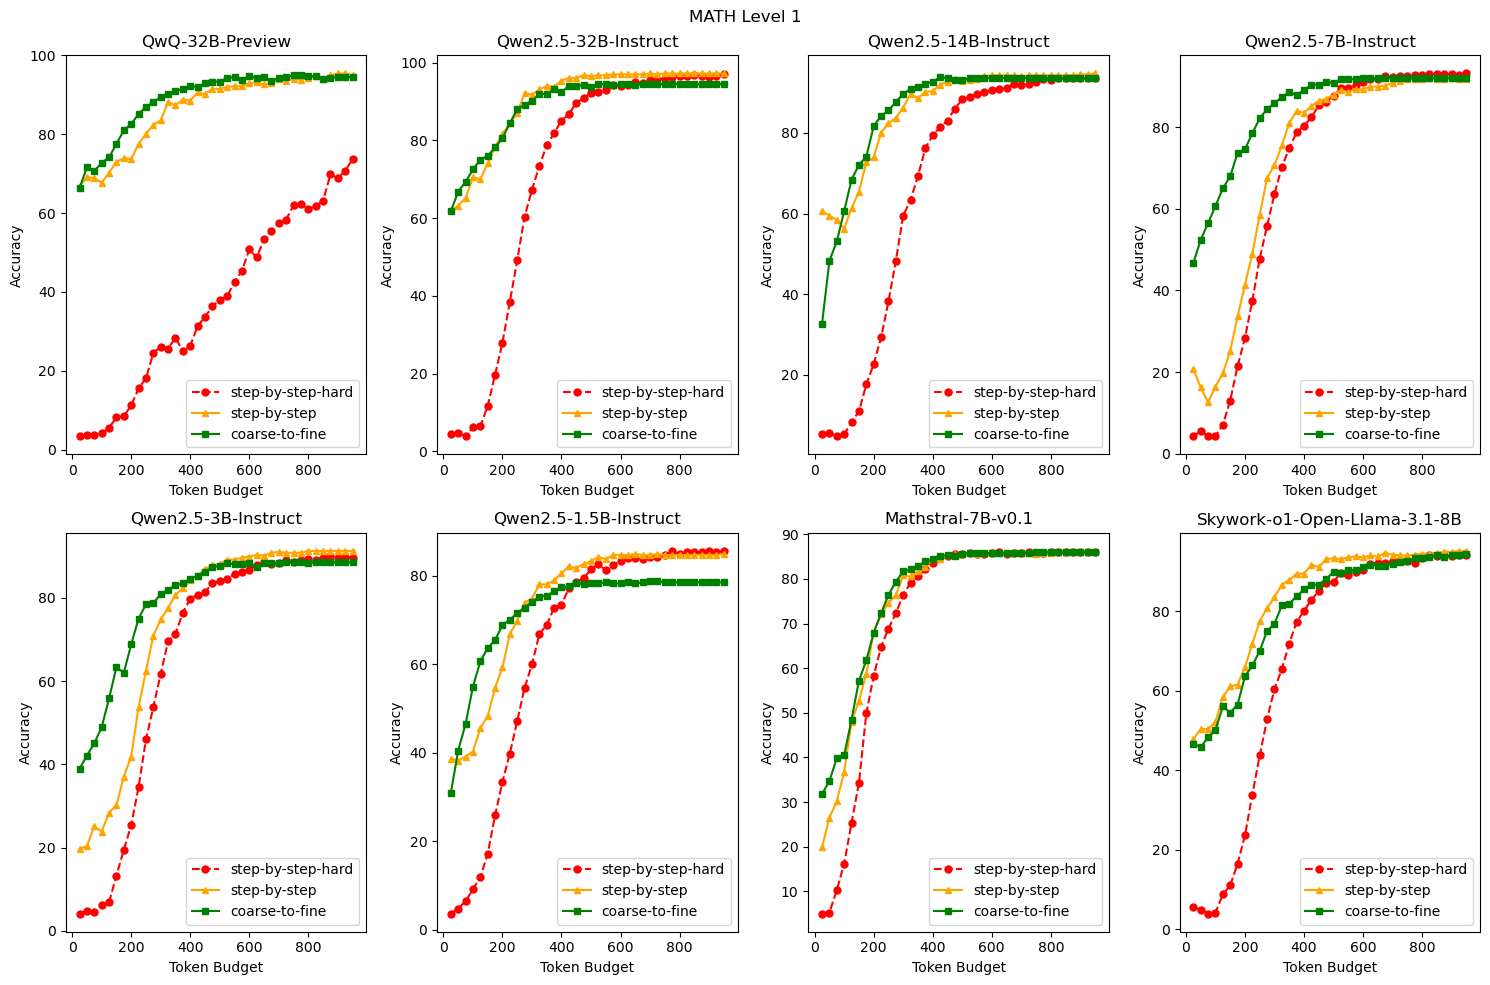

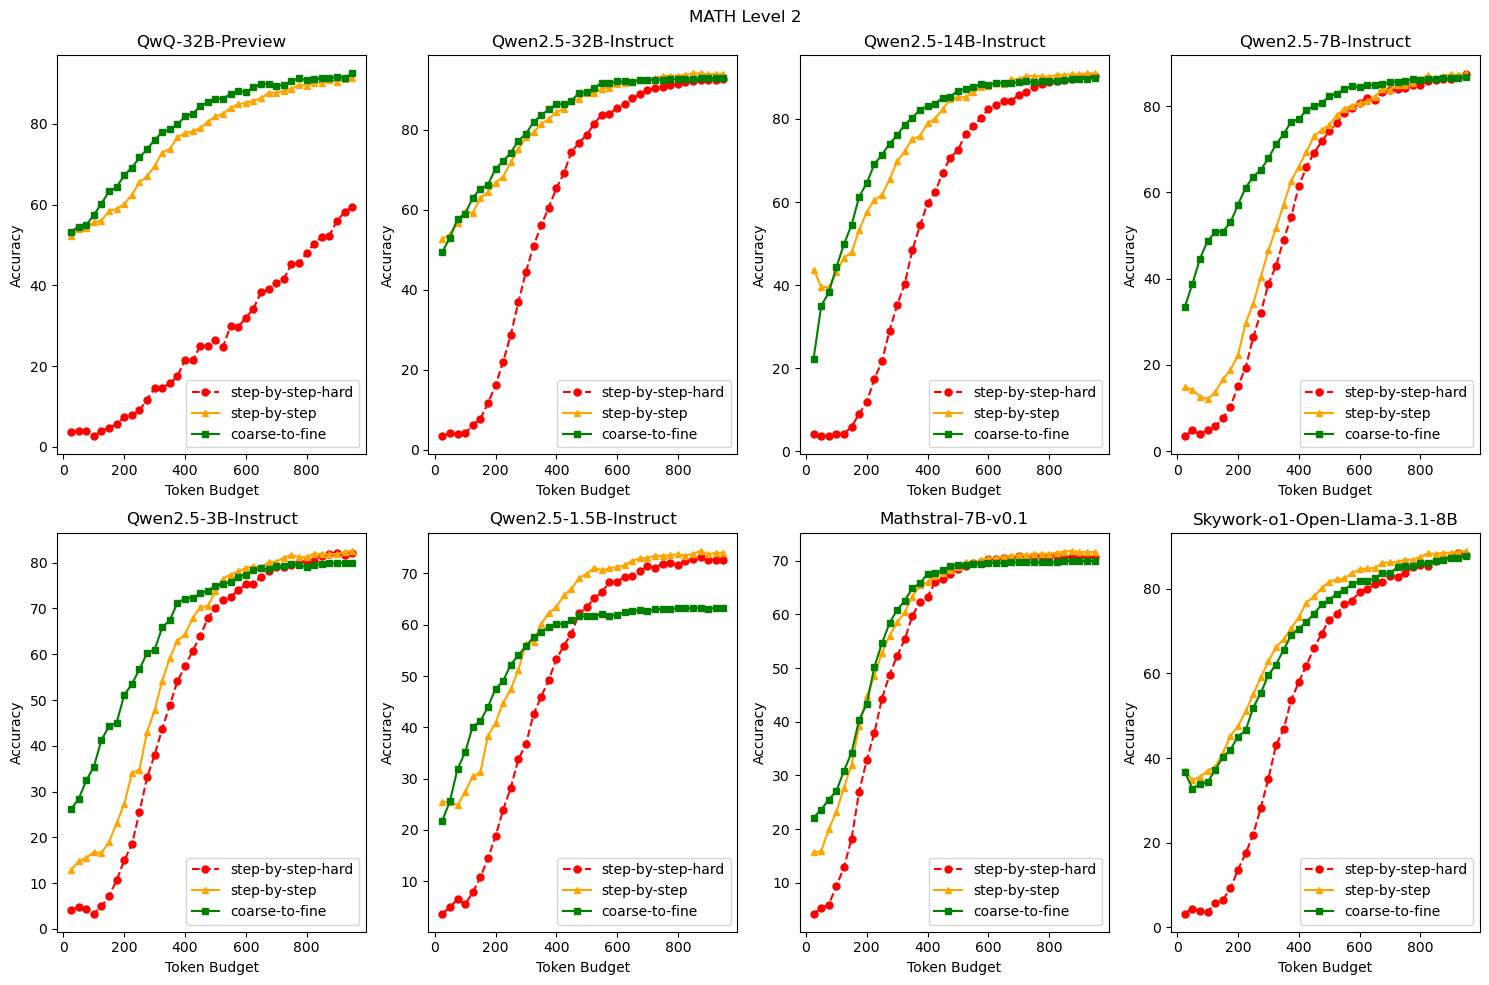

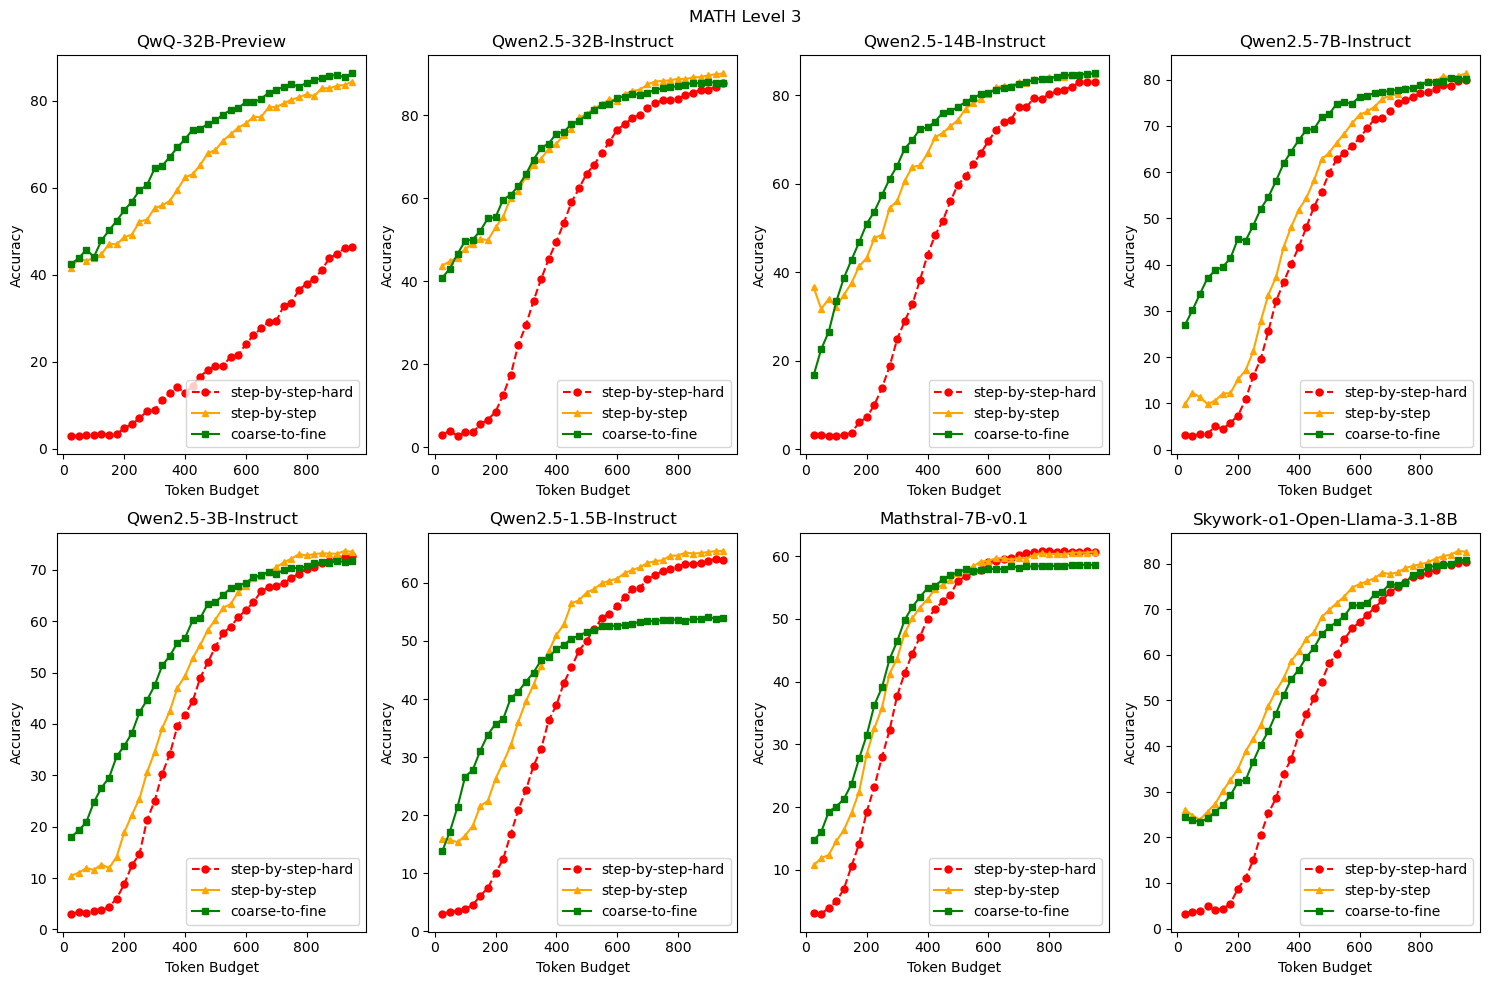

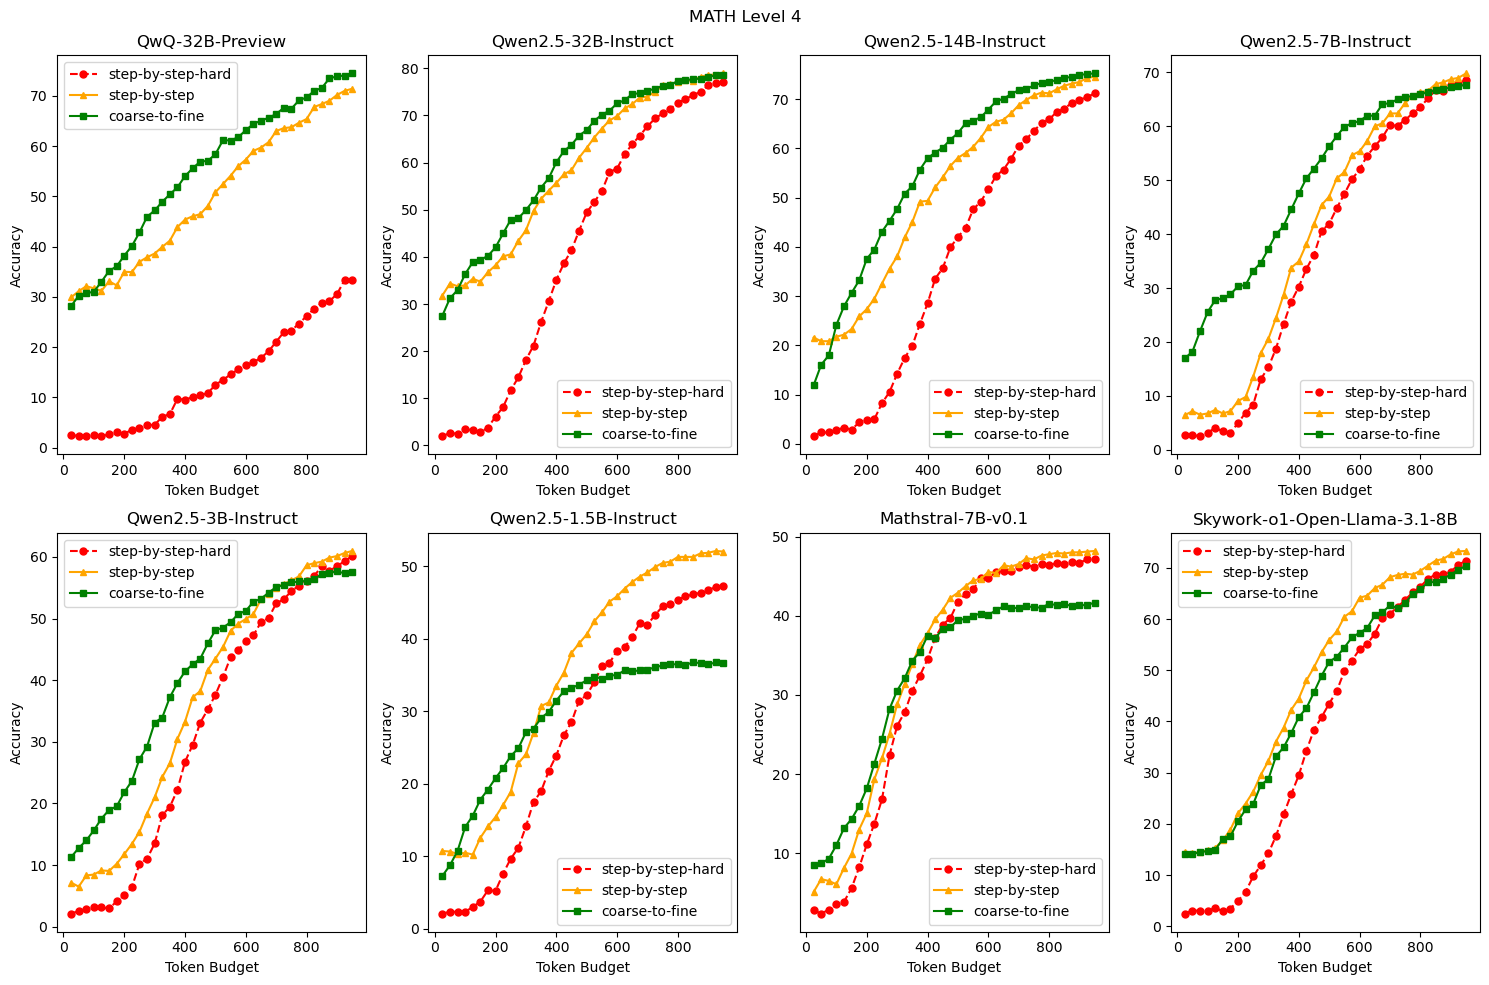

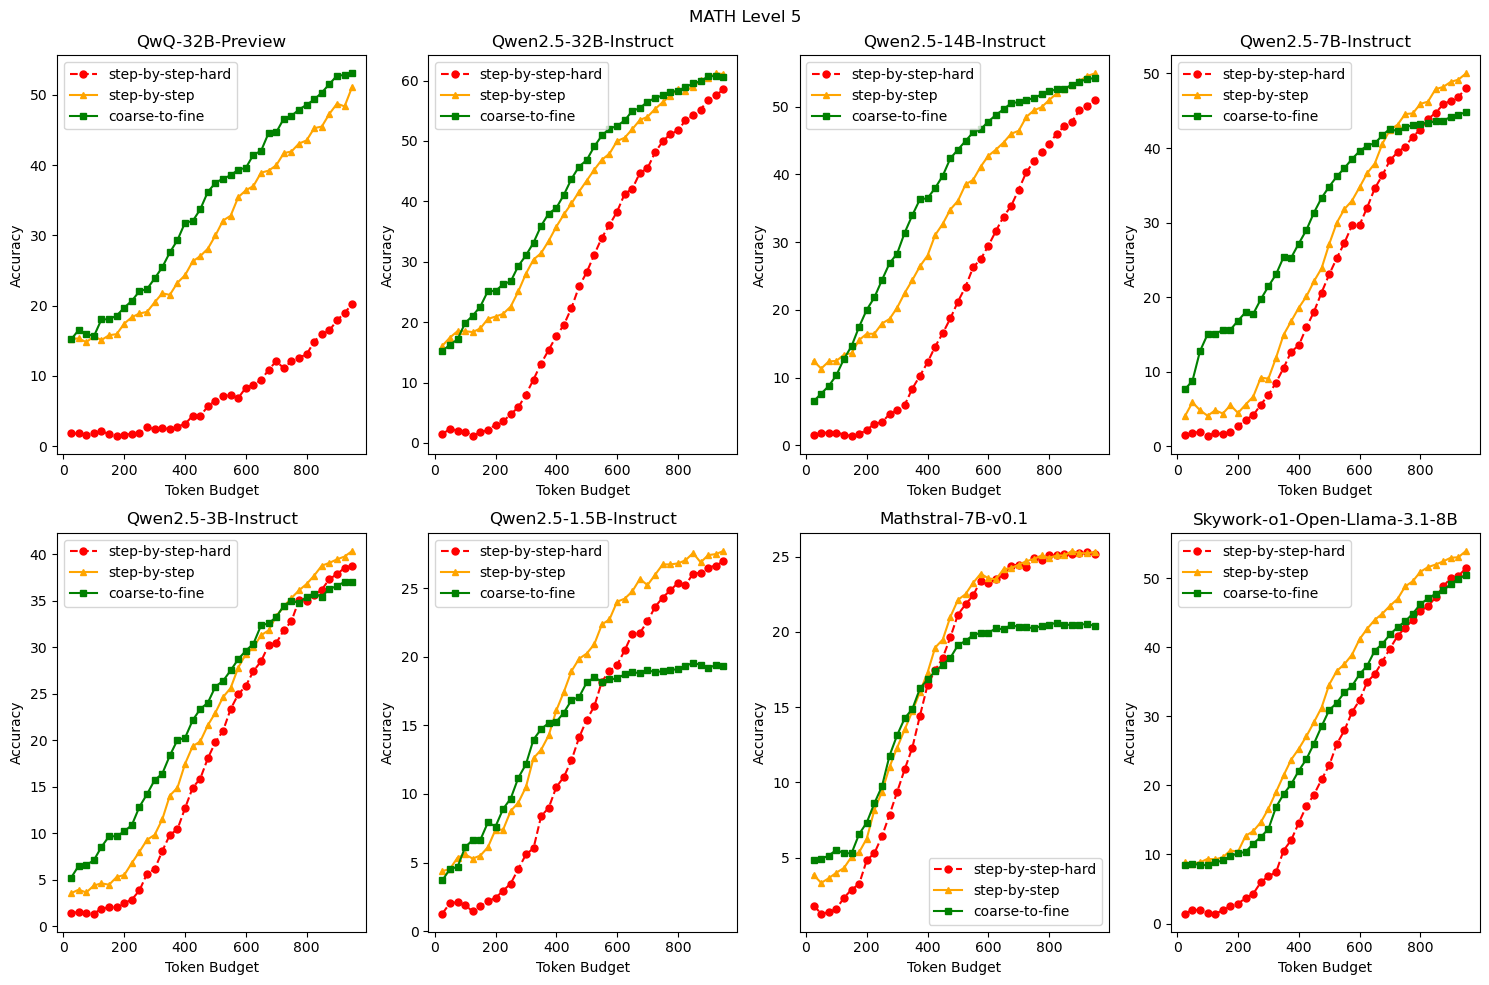

In [37]:
# plot and show 5 figures in total for 5 levels, each one is 2x3

for level in range(1, 6):
    fig, axs = plt.subplots(2, 4, figsize=(15, 10))
    marker_size = 5  # Set the desired marker size

    # Flatten the axes array for easy iteration
    axs = axs.flatten()
    # Plot all lines first without labels
    for index, model in enumerate(model_list):
        axs[index].plot(budget_list1, [acc["Level " + str(level)] for acc in acc_lists1[index]], marker='o', markersize=marker_size, 
                            linestyle='--', color="red", label="step-by-step-hard")
        axs[index].plot(budget_list1, [acc["Level " + str(level)] for acc in acc_lists2[index]], marker='^', markersize=marker_size, 
                        linestyle='-', color="orange", label="step-by-step")
        axs[index].plot(budget_list1, [acc["Level " + str(level)] for acc in acc_lists3[index]], marker='s', markersize=marker_size,     
                        linestyle='-', color="green", label="coarse-to-fine")
        axs[index].set_xlabel("Token Budget")
        axs[index].set_ylabel("Accuracy")
        axs[index].set_title(f"{model.split('/')[-1]}")
        axs[index].legend()

    # set the title
    plt.suptitle(f"{dataset}".upper() + " Level " + str(level))
    # Adjust layout
    plt.tight_layout()
    plt.show()

In [38]:
def get_subject_acc(data_path):
    data_list = load_jsonl(data_path)
    accs = {
        "Prealgebra": [],
        "Precalculus": [],
        "Geometry": [],
        "Intermediate Algebra": [],
        "Counting & Probability": [],
        "Algebra": [],
        "Number Theory": []
    }
    nums = {
        "Prealgebra": 0,
        "Precalculus": 0,
        "Geometry": 0,
        "Intermediate Algebra": 0,
        "Counting & Probability": 0,
        "Algebra": 0,
        "Number Theory": 0
    }
    for data in data_list:
        accs[data["subject"]].append(data["score"][0])
        nums[data["subject"]] += 1
    for subject in accs:
        accs[subject] = round(np.mean(accs[subject]) * 100, 2)
    # print(accs)
    # print(nums)
    # print("sum of nums:", sum(nums.values()))
    # # save the accs to the metric_path
    # with open(metric_path, "r", encoding="utf-8") as f:
    #     metrics = json.load(f)
    #     for i in range(5):
    #         metrics["Level " + str(i + 1)] = accs["Level " + str(i + 1)]
    # with open(metric_path, "w", encoding="utf-8") as f:
    #     json.dump(metrics, f)
    return accs


test_data_path = "/home/sunyi/CoT/Time-Constrained-CoT/outputs/12_26/Qwen/Qwen2.5-7B-Instruct/qwen25-math-cot/math/test_qwen25-math-cot_-1_seed0_t0.0_s0_e-1_b200.jsonl"
test_metric_path = "/home/sunyi/CoT/Time-Constrained-CoT/outputs/12_26/Qwen/Qwen2.5-7B-Instruct/qwen25-math-cot/math/test_qwen25-math-cot_-1_seed0_t0.0_s0_e-1_b200_metrics.json"
get_subject_acc(test_data_path)

{'Prealgebra': 25.37,
 'Precalculus': 11.9,
 'Geometry': 11.48,
 'Intermediate Algebra': 7.97,
 'Counting & Probability': 11.18,
 'Algebra': 16.85,
 'Number Theory': 10.19}

In [39]:
# plot acc for each subject

acc_lists1 = []
acc_lists2 = []
acc_lists3 = []

for model in model_list:
    acc_list1 = []
    acc_list2 = []
    acc_list3 = []
    for budget in budget_list1:
        if model.startswith("Qwen"):
            data_file2 = "test_" + prompt_type2 + something + "_b" + str(int(budget)) + ".jsonl"
            data_file3 = "test_" + prompt_type3 + something + "_b" + str(int(budget)) + ".jsonl"
            data_path2 = os.path.join(file_dir, model, prompt_type2, dataset, data_file2)
            data_path3 = os.path.join(file_dir, model, prompt_type3, dataset, data_file3)
        elif model.startswith("mistralai"):
            data_file2 = "test_" + prompt_type5 + something + "_b" + str(int(budget)) + ".jsonl"
            data_file3 = "test_" + prompt_type6 + something + "_b" + str(int(budget)) + ".jsonl"
            data_path2 = os.path.join(file_dir, model, prompt_type5, dataset, data_file2)
            data_path3 = os.path.join(file_dir, model, prompt_type6, dataset, data_file3)
        elif model.startswith("Skywork"):
            data_file2 = "test_" + prompt_type8 + something + "_b" + str(int(budget)) + ".jsonl"
            data_file3 = "test_" + prompt_type9 + something + "_b" + str(int(budget)) + ".jsonl"
            data_path2 = os.path.join(file_dir, model, prompt_type8, dataset, data_file2)
            data_path3 = os.path.join(file_dir, model, prompt_type9, dataset, data_file3)
        acc_list2.append(get_subject_acc(data_path2))
        acc_list3.append(get_subject_acc(data_path3))
    for budget in budget_list2:
        if model.startswith("Qwen"):
            data_file1 = "test_" + prompt_type1 + something + "_b" + str(int(budget)) + ".jsonl"
            data_path1 = os.path.join(file_dir, model, prompt_type1, dataset, data_file1)
        elif model.startswith("mistralai"):
            data_file1 = "test_" + prompt_type4 + something + "_b" + str(int(budget)) + ".jsonl"
            data_path1 = os.path.join(file_dir, model, prompt_type4, dataset, data_file1)
        elif model.startswith("Skywork"):
            data_file1 = "test_" + prompt_type7 + something + "_b" + str(int(budget)) + ".jsonl"
            data_path1 = os.path.join(file_dir, model, prompt_type7, dataset, data_file1)
        acc_list1.append(get_subject_acc(data_path1))
    acc_lists1.append(acc_list1)
    acc_lists2.append(acc_list2)
    acc_lists3.append(acc_list3)


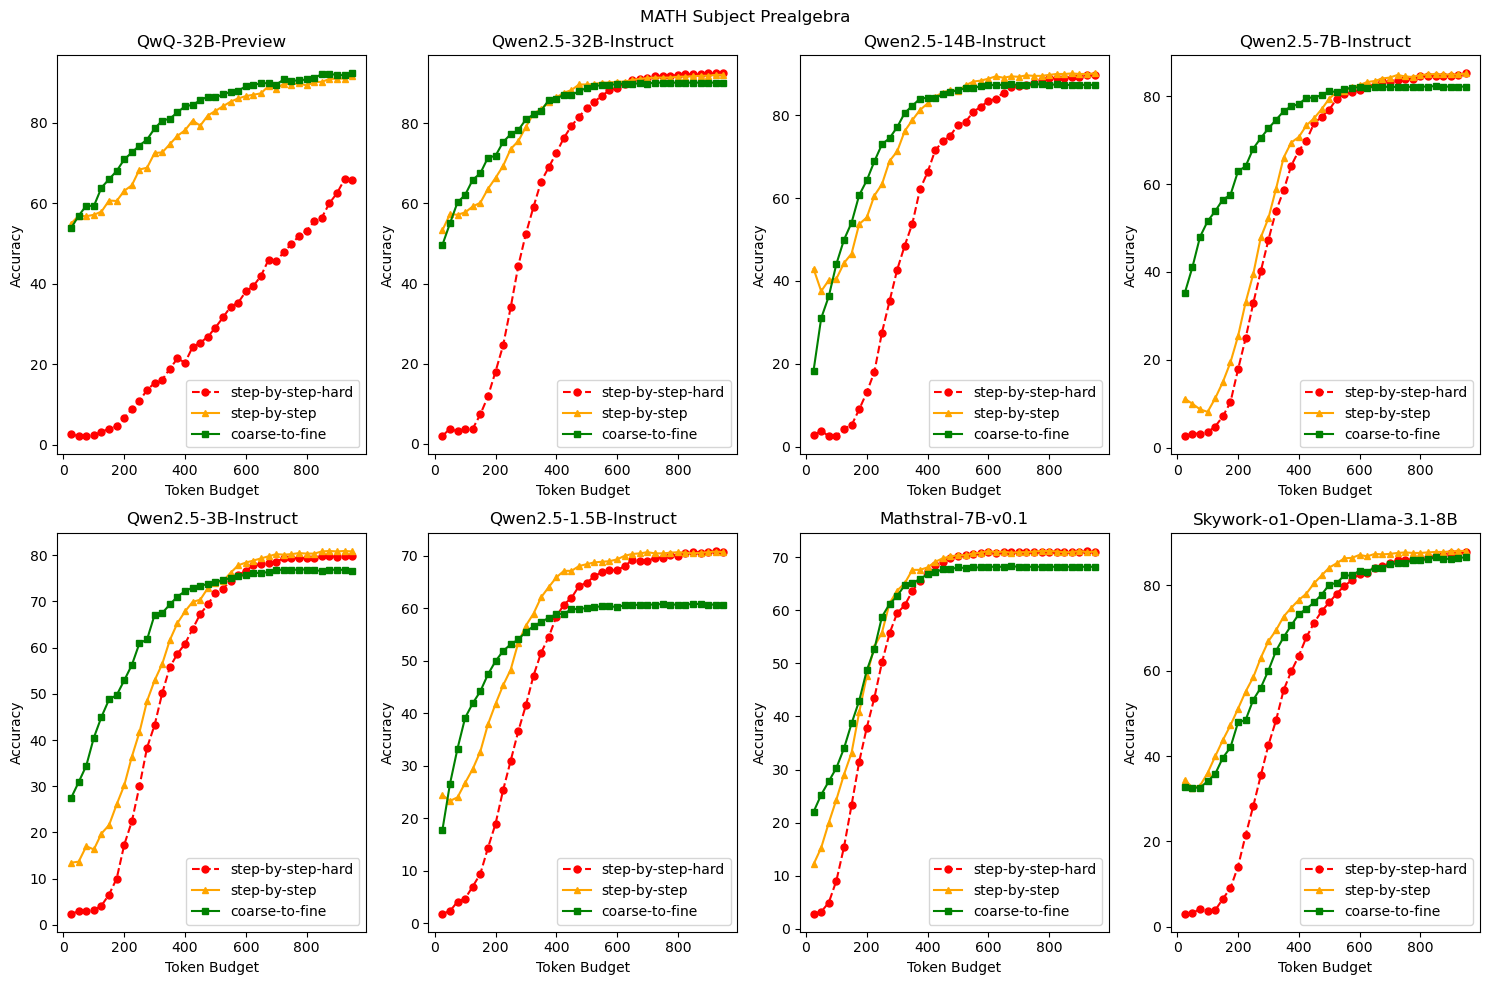

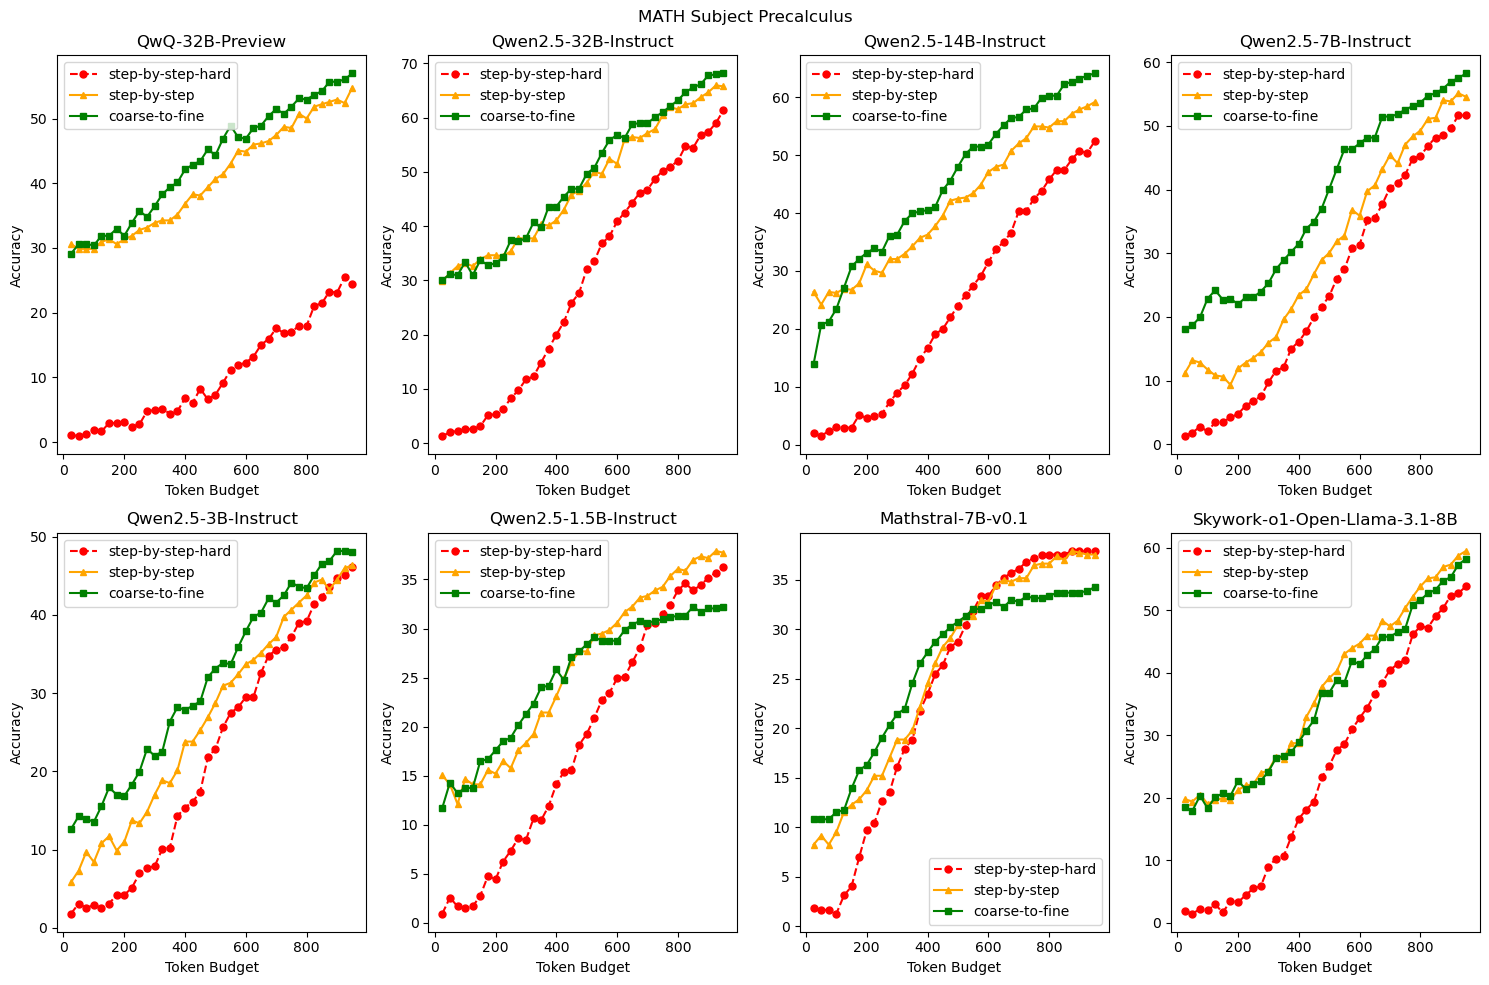

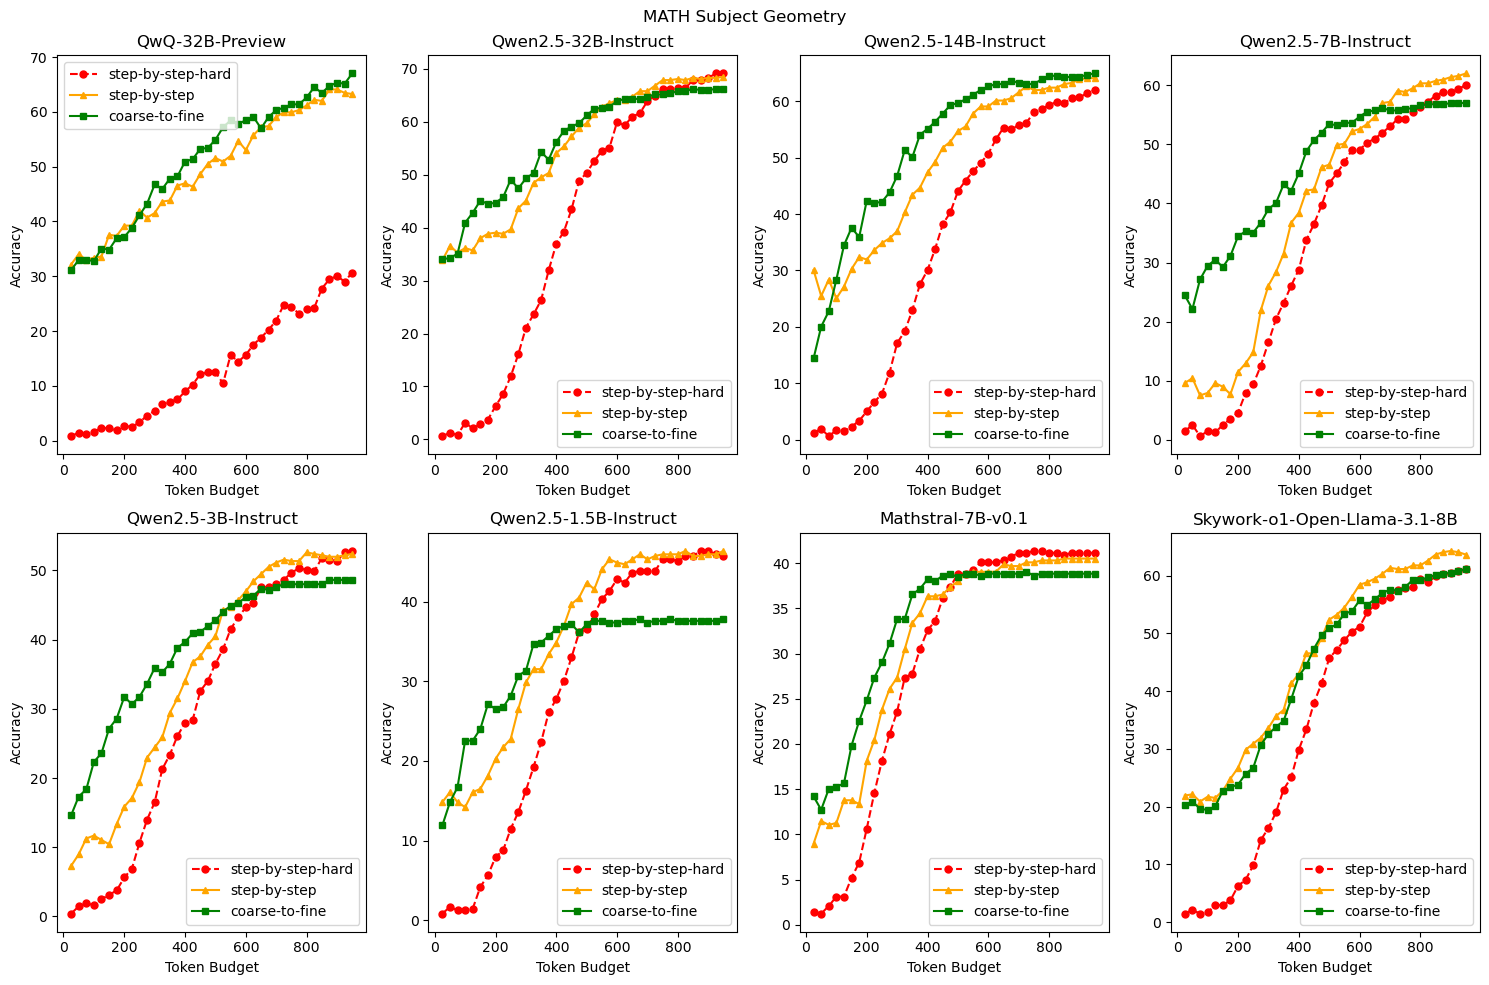

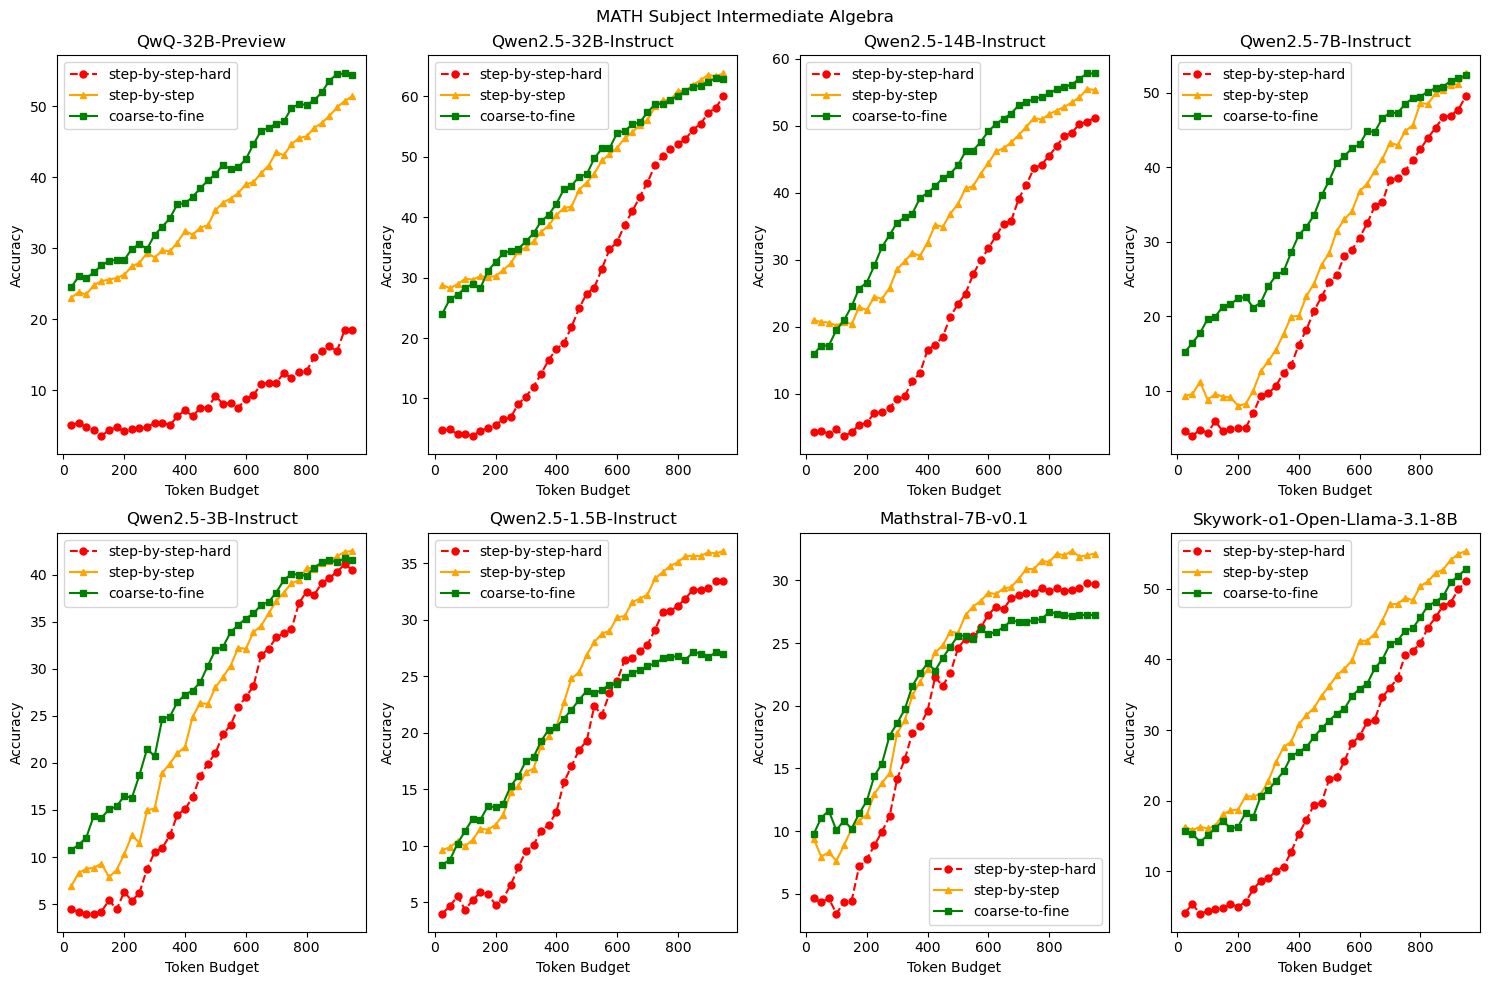

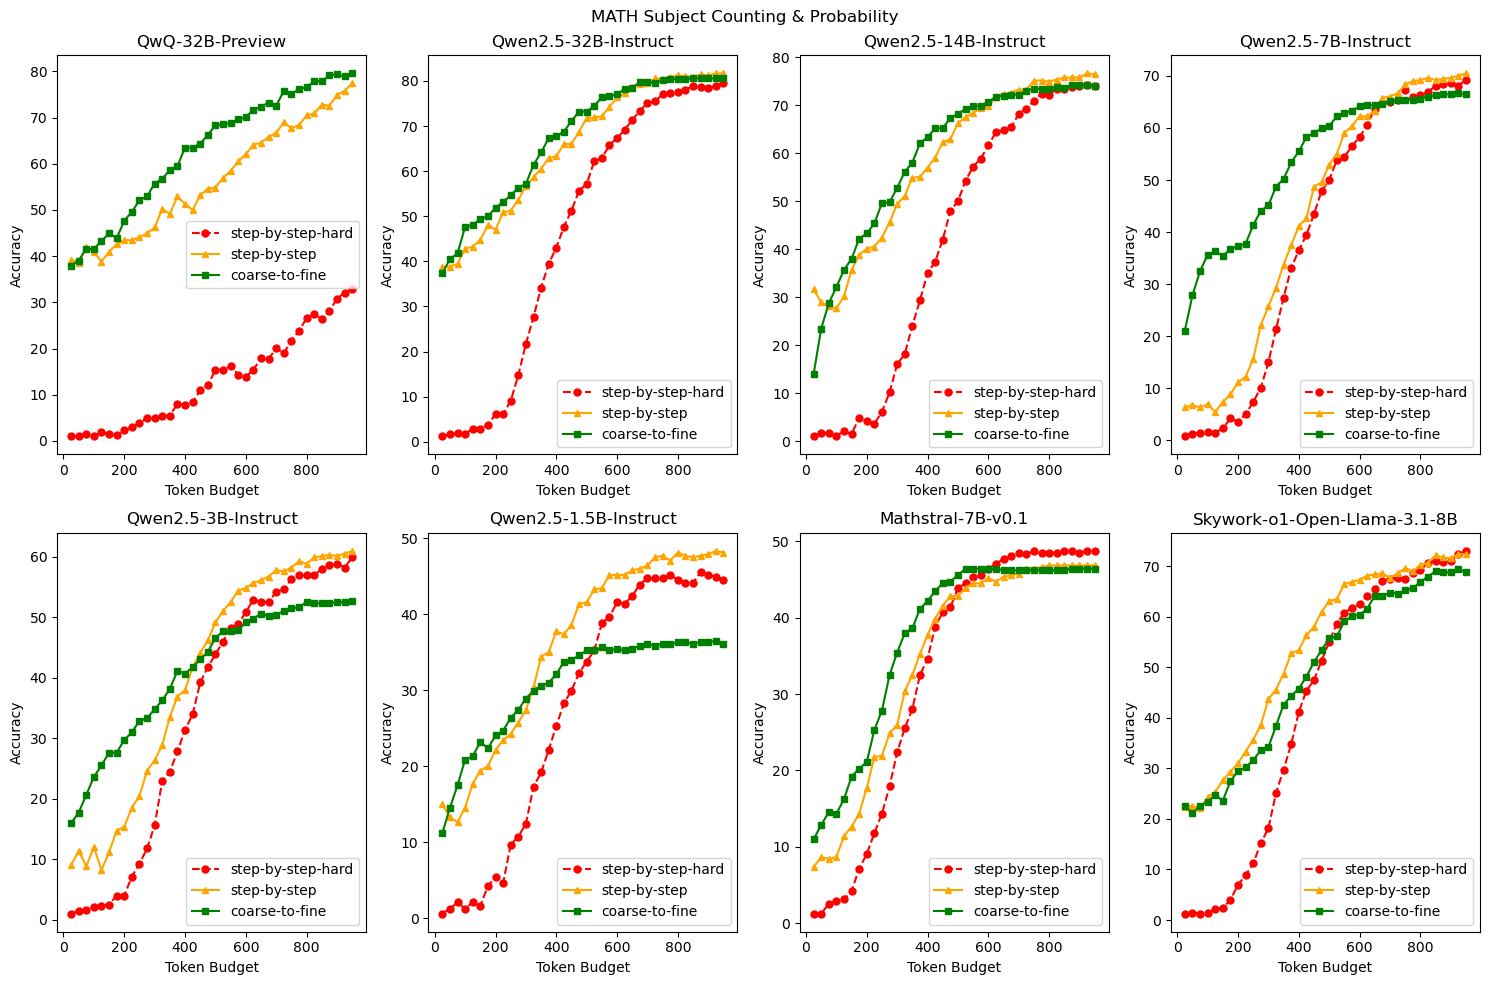

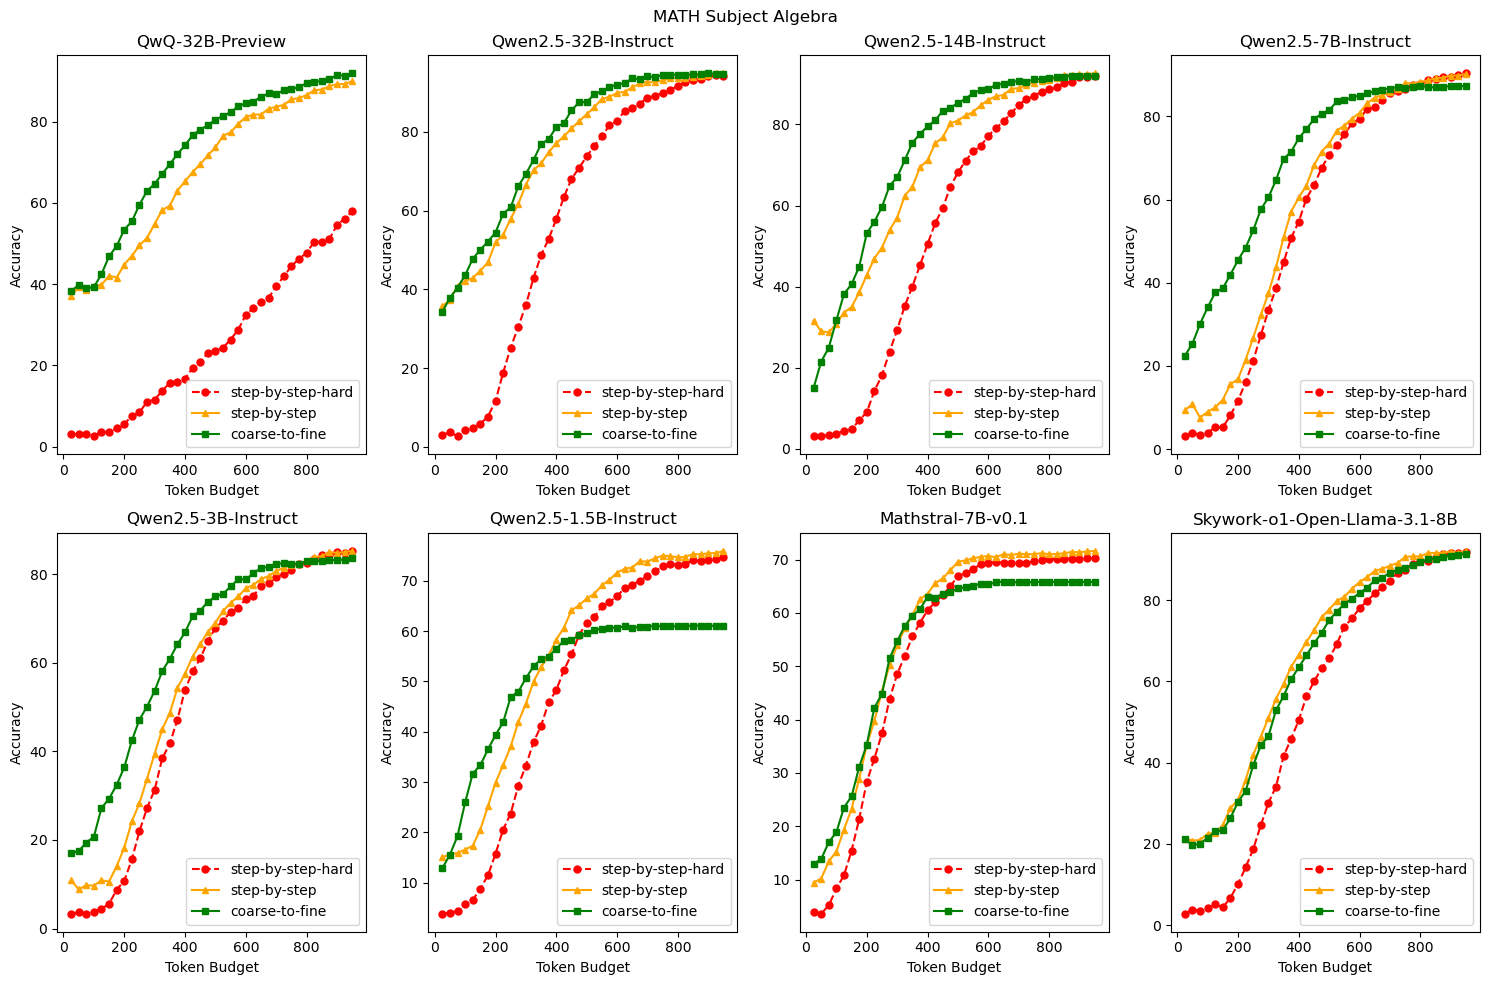

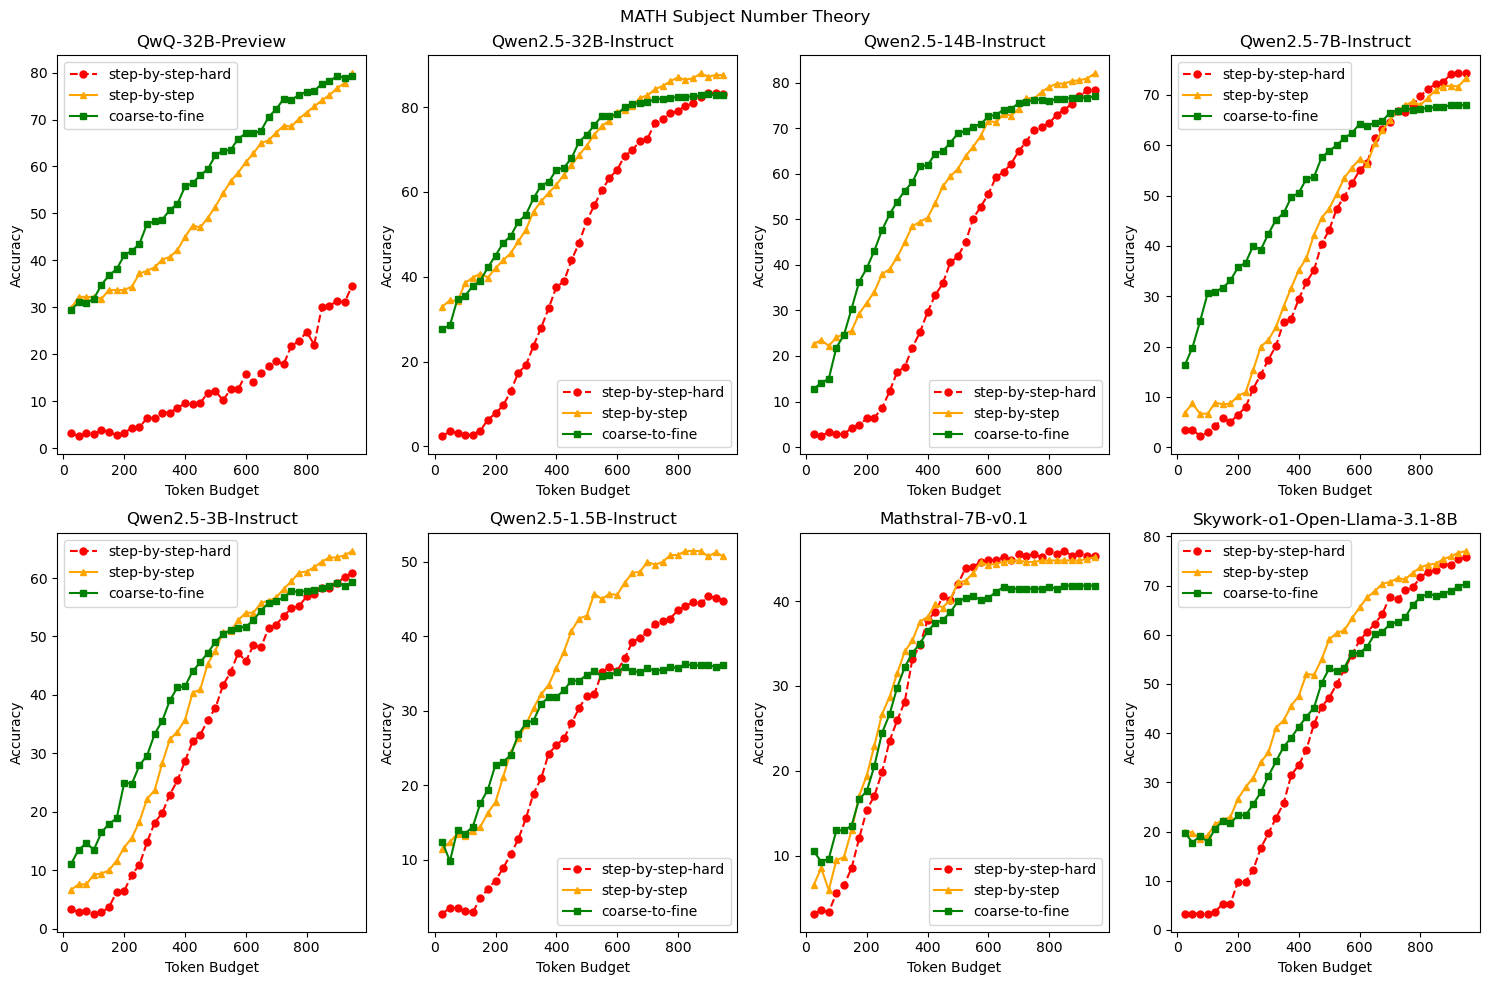

In [40]:
# plot and show 7 figures in total for 7 subjects, each one is 2x3

for subject in ["Prealgebra", "Precalculus", "Geometry", "Intermediate Algebra", "Counting & Probability", "Algebra", "Number Theory"]:
    fig, axs = plt.subplots(2, 4, figsize=(15, 10))
    marker_size = 5  # Set the desired marker size

    # Flatten the axes array for easy iteration
    axs = axs.flatten()
    # Plot all lines first without labels
    for index, model in enumerate(model_list):
        axs[index].plot(budget_list1, [acc[subject] for acc in acc_lists1[index]], marker='o', markersize=marker_size, 
                            linestyle='--', color="red", label="step-by-step-hard")
        axs[index].plot(budget_list1, [acc[subject] for acc in acc_lists2[index]], marker='^', markersize=marker_size, 
                        linestyle='-', color="orange", label="step-by-step")
        axs[index].plot(budget_list1, [acc[subject] for acc in acc_lists3[index]], marker='s', markersize=marker_size,     
                        linestyle='-', color="green", label="coarse-to-fine")
        axs[index].set_xlabel("Token Budget")
        axs[index].set_ylabel("Accuracy")
        axs[index].set_title(f"{model.split('/')[-1]}")
        axs[index].legend()

    # set the title
    plt.suptitle(f"{dataset}".upper() + " Subject " + subject)
    # Adjust layout
    plt.tight_layout()
    plt.show()